# 네이버 영화리뷰 감성분석

## 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터 변수 지정
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()    # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 데이터 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace = True)
    test_data = test_data.dropna(how='any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # Train Data 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # Test Data토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word : index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index 
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index : word for word, index in word_to_index.items()}

In [4]:
print(word_to_index['영화'])

5


In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델 구성을 위한 데이터 분석 및 가공

#### 데이터셋 내 문장 길이 분포 & 적절한 최대 문장 길이 지정

In [6]:
total_data_text = list(X_train) + list(X_test)

# 텍스트 데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산해본다.
print("문장 길이의 평균 : ", np.mean(num_tokens))
print("문장 길이의 최대 : ", np.max(num_tokens))
print("문장 길이 표준 편차 : ", np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) +4*np.std(num_tokens)
maxlen = int(max_tokens)
print("pad_sequences maxlen : ", maxlen)
print("전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.".format(np.sum(num_tokens<max_tokens)/len(num_tokens)))

문장 길이의 평균 :  15.969376315021577
문장 길이의 최대 :  116
문장 길이 표준 편차 :  12.843535456326455
pad_sequences maxlen :  67
전체 문장의 0.99755809131817%가 maxlen 설정값 이내에 포함됩니다.


#### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [7]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                            value = word_to_index['<PAD>'],
                            padding = 'post', maxlen = maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                            value = word_to_index['<PAD>'],
                            padding = 'post', maxlen = maxlen)
print(x_train.shape)

(146182, 67)


In [8]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
라벨:  0


## 4) 모델구성 및 validation set 구성

In [9]:
vocab_size = 10000 # 어휘 사전의 크기
word_vector_dim = 16 # 임베딩 벡터의 차원

### RNN 모델

In [10]:
rnn_model = keras.Sequential()
rnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model.add(keras.layers.LSTM(8))
rnn_model.add(keras.layers.Dense(128, activation='relu'))
rnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 162,081
Trainable params: 162,081
Non-trainable params: 0
_________________________________________________________________


### CNN 모델

In [11]:
cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(keras.layers.MaxPooling1D(5))
cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(keras.layers.GlobalMaxPooling1D())
cnn_model.add(keras.layers.Dense(128, activation='relu'))
cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### GlobalMaxPooling 모델

In [12]:
gmp_model = keras.Sequential()
gmp_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmp_model.add(keras.layers.GlobalMaxPooling1D())
gmp_model.add(keras.layers.Dense(128, activation='relu'))
gmp_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gmp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 162,305
Trainable params: 162,305
Non-trainable params: 0
_________________________________________________________________


#### validation 데이터 분리

In [13]:
# validation set 10000건 분리
x_val = x_train[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 67)
(136182,)


## 5) 모델 훈련 개시

### RNN 모델

In [14]:
rnn_model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy', 
             metrics=['accuracy'])

epochs = 5

rnn_history = rnn_model.fit(partial_x_train, partial_y_train,
                   epochs = epochs, batch_size = 512,
                   validation_data = (x_val, y_val),
                   verbose = 1)

Epoch 1/5
266/266 [==============================] - 2s 8ms/step - loss: 0.6646 - accuracy: 0.5489 - val_loss: 0.4313 - val_accuracy: 0.8194
Epoch 2/5
266/266 [==============================] - 2s 6ms/step - loss: 0.3669 - accuracy: 0.8411 - val_loss: 0.3462 - val_accuracy: 0.8507
Epoch 3/5
266/266 [==============================] - 2s 7ms/step - loss: 0.3239 - accuracy: 0.8629 - val_loss: 0.3419 - val_accuracy: 0.8498
Epoch 4/5
266/266 [==============================] - 2s 8ms/step - loss: 0.3117 - accuracy: 0.8684 - val_loss: 0.3412 - val_accuracy: 0.8531
Epoch 5/5
266/266 [==============================] - 2s 9ms/step - loss: 0.3018 - accuracy: 0.8726 - val_loss: 0.3439 - val_accuracy: 0.8505


In [15]:
results = rnn_model.evaluate(x_test, y_test, verbose = 2)
print(results)

1537/1537 - 4s - loss: 0.3533 - accuracy: 0.8459
[0.3532644808292389, 0.8459426164627075]


### CNN 모델

In [16]:
cnn_model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy', 
             metrics=['accuracy'])

epochs = 5

cnn_history = cnn_model.fit(partial_x_train, partial_y_train,
                   epochs = epochs, batch_size = 512,
                   validation_data = (x_val, y_val),
                   verbose = 1)

Epoch 1/5
266/266 [==============================] - 7s 27ms/step - loss: 0.4615 - accuracy: 0.7718 - val_loss: 0.3395 - val_accuracy: 0.8510
Epoch 2/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3144 - accuracy: 0.8672 - val_loss: 0.3276 - val_accuracy: 0.8577
Epoch 3/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2781 - accuracy: 0.8860 - val_loss: 0.3301 - val_accuracy: 0.8559
Epoch 4/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2450 - accuracy: 0.9026 - val_loss: 0.3407 - val_accuracy: 0.8549
Epoch 5/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2095 - accuracy: 0.9196 - val_loss: 0.3689 - val_accuracy: 0.8526


In [17]:
results = cnn_model.evaluate(x_test, y_test, verbose = 2)
print(results)

1537/1537 - 3s - loss: 0.3799 - accuracy: 0.8498
[0.37988632917404175, 0.8498281240463257]


### GlobalMaxPooling 모델

In [18]:
gmp_model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy', 
             metrics=['accuracy'])

epochs = 5

gmp_history = gmp_model.fit(partial_x_train, partial_y_train,
                   epochs = epochs, batch_size = 512,
                   validation_data = (x_val, y_val),
                   verbose = 1)

Epoch 1/5
266/266 [==============================] - 1s 5ms/step - loss: 0.4944 - accuracy: 0.7703 - val_loss: 0.3665 - val_accuracy: 0.8386
Epoch 2/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3388 - accuracy: 0.8536 - val_loss: 0.3481 - val_accuracy: 0.8462
Epoch 3/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3042 - accuracy: 0.8714 - val_loss: 0.3481 - val_accuracy: 0.8488
Epoch 4/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2822 - accuracy: 0.8819 - val_loss: 0.3548 - val_accuracy: 0.8472
Epoch 5/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2653 - accuracy: 0.8911 - val_loss: 0.3651 - val_accuracy: 0.8458


In [19]:
results = gmp_model.evaluate(x_test, y_test, verbose = 2)
print(results)

1537/1537 - 2s - loss: 0.3753 - accuracy: 0.8415
[0.375287264585495, 0.8415077924728394]


## 6) Loss, Accuracy 그래프 시각화

### RNN 모델

In [20]:
rnn_history_dict = rnn_history.history
print(rnn_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


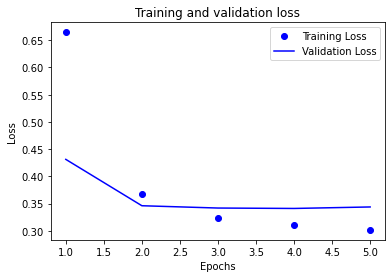

In [21]:
import matplotlib.pyplot as plt

acc = rnn_history_dict['accuracy']
val_acc = rnn_history_dict['val_accuracy']
loss = rnn_history_dict['loss']
val_loss = rnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

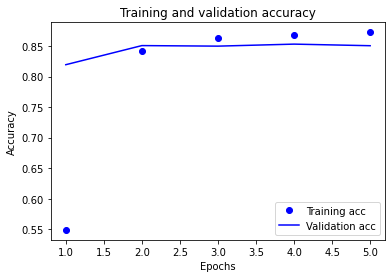

In [22]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### CNN 모델

In [23]:
cnn_history_dict = cnn_history.history
print(cnn_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


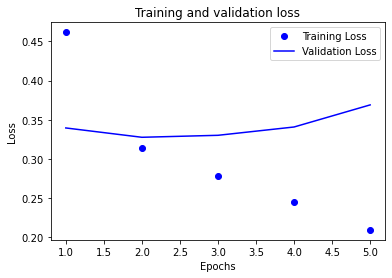

In [24]:
import matplotlib.pyplot as plt

acc = cnn_history_dict['accuracy']
val_acc = cnn_history_dict['val_accuracy']
loss = cnn_history_dict['loss']
val_loss = cnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

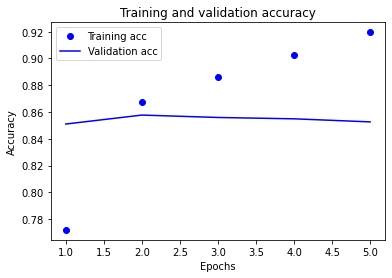

In [25]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### GlobalMaxPooling 모델

In [26]:
gmp_history_dict = gmp_history.history
print(gmp_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


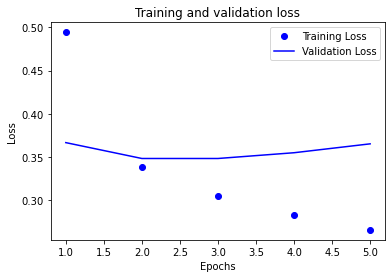

In [27]:
import matplotlib.pyplot as plt

acc = gmp_history_dict['accuracy']
val_acc = gmp_history_dict['val_accuracy']
loss = gmp_history_dict['loss']
val_loss = gmp_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

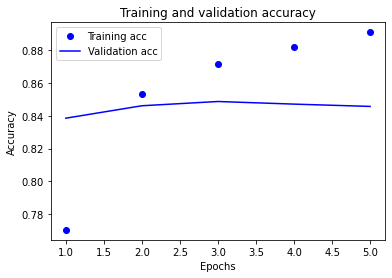

In [28]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

### RNN 모델 임베딩 레이어 분석

In [29]:
embedding_layer = rnn_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [36]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
rnn_embedding_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/rnn_embedding_file.txt'
rnn_f = open(rnn_embedding_file_path, 'w')
rnn_f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수에서 워드 벡터를 파일에 기록합니다. 
vectors = rnn_model.get_weights()[0]
for i in range(4,vocab_size):
    rnn_f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(rnn_vectors[i, :])))))
rnn_f.close()

In [37]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

rnn_word_vectors = Word2VecKeyedVectors.load_word2vec_format(rnn_embedding_file_path, binary=False)
rnn_vector = rnn_word_vectors['영화']
rnn_vector

array([-0.02381157,  0.08878078, -0.06384844,  0.0166304 ,  0.02728365,
        0.04876624,  0.01235634, -0.08366036,  0.04130024, -0.02109956,
       -0.0140447 , -0.05994527,  0.03944831, -0.0360024 ,  0.0543525 ,
        0.022956  ], dtype=float32)

In [38]:
rnn_word_vectors.similar_by_word("영화")

[('비꼬', 0.8564373254776001),
 ('하이틴', 0.8383093476295471),
 ('컴퓨터', 0.83084636926651),
 ('카모', 0.8288395404815674),
 ('했으면', 0.8232689499855042),
 ('생물', 0.8167996406555176),
 ('될까요', 0.8152933120727539),
 ('겠다는', 0.8115453124046326),
 ('생기', 0.8088719844818115),
 ('맘마', 0.8072699308395386)]

### CNN 모델 임베딩 레이어 분석

In [39]:
embedding_layer = cnn_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [40]:
cnn_embedding_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/cnn_embedding_file.txt'
cnn_f = open(cnn_embedding_file_path, 'w')
cnn_f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = cnn_model.get_weights()[0]
for i in range(4,vocab_size):
    cnn_f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
cnn_f.close()

In [41]:
cnn_word_vectors = Word2VecKeyedVectors.load_word2vec_format(cnn_embedding_file_path, binary=False)
cnn_vector = cnn_word_vectors['영화']
cnn_vector

array([-0.00841768, -0.0359221 , -0.06873745,  0.03398536,  0.08593449,
        0.00586432,  0.0368223 , -0.01942282,  0.01322161,  0.01149981,
        0.02261522,  0.02987076,  0.01180329,  0.03670038, -0.01856823,
        0.01908065], dtype=float32)

In [42]:
cnn_word_vectors.similar_by_word("영화")

[('엑소', 0.8920615911483765),
 ('유치원', 0.8292217254638672),
 ('직원', 0.7826623916625977),
 ('소중', 0.7818369269371033),
 ('레인져', 0.7564802169799805),
 ('EBS', 0.7515896558761597),
 ('태극', 0.7508716583251953),
 ('으아', 0.7246770858764648),
 ('흘러가', 0.7212649583816528),
 ('하이틴', 0.7184116840362549)]

### GlobalMaxPooling 모델

In [43]:
embedding_layer = gmp_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [44]:
gmp_embedding_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/gmp_embedding_file.txt'
gmp_f = open(gmp_embedding_file_path, 'w')
gmp_f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = gmp_model.get_weights()[0]
for i in range(4,vocab_size):
    gmp_f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
gmp_f.close()

In [45]:
gmp_word_vectors = Word2VecKeyedVectors.load_word2vec_format(gmp_embedding_file_path, binary=False)
gmp_vector = gmp_word_vectors['영화']
gmp_vector

array([-0.03778738, -0.03563118, -0.05741322, -0.04992018, -0.11737786,
       -0.07699184, -0.0802915 , -0.05360702, -0.13324903, -0.08878486,
       -0.06014612, -0.07845043, -0.05568938, -0.03680178, -0.10682882,
       -0.08305455], dtype=float32)

In [46]:
gmp_word_vectors.similar_by_word("영화")

[('다', 0.9753773212432861),
 ('하', 0.973933219909668),
 ('너무', 0.9731730222702026),
 ('아', 0.971085786819458),
 ('.', 0.970085084438324),
 ('음', 0.9625014066696167),
 ('이것', 0.9603286981582642),
 ('이야기', 0.9541827440261841),
 ('/', 0.9491609334945679),
 ('까지', 0.9451295137405396)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [47]:
import gensim
from gensim.models import KeyedVectors

kor_word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.bin'
kor_word2vec = gensim.models.Word2Vec.load(kor_word2vec_path)
kor_vector = kor_word2vec['영화']
kor_vector

/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-1.7577837 , -1.0874279 ,  1.5300866 , -0.1115231 , -0.37980682,
        1.4828517 ,  1.3180419 ,  0.11094163,  0.7430535 , -0.45461136,
        0.58841336,  0.5763913 ,  1.210707  ,  1.3132795 , -0.86962503,
       -0.18507595, -0.47440064,  1.5100725 ,  1.0965794 ,  1.0600823 ,
       -0.27457932, -0.70003706,  2.3117511 ,  1.4944884 ,  0.25560892,
       -2.866659  , -0.28312334,  0.34263936, -0.67723423,  0.71714777,
        0.25549442,  0.71732044, -0.13262457,  0.01792452, -0.3184774 ,
        0.5271619 ,  0.7561084 , -2.1247065 ,  1.061429  , -0.21065854,
        0.6877343 , -1.4956383 ,  0.60346967, -2.6955893 ,  0.37694618,
       -1.0164185 ,  0.5430663 ,  0.1200121 , -2.6315718 ,  0.6216742 ,
        1.1583976 , -2.5385962 ,  1.326312  , -0.10284371, -0.0286147 ,
       -0.9132947 ,  0.7647564 ,  0.79202783, -1.8625957 , -0.7418395 ,
        0.5884277 , -0.9917992 , -0.62114453,  1.5367815 , -0.6628939 ,
        0.6712103 ,  0.12914915,  0.21228492,  0.9017655 , -0.25

In [48]:
kor_word2vec.similar_by_word("영화")

/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.7052942514419556),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571459174156189),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428800821304321),
 ('애니메이션', 0.6425570249557495)]

In [55]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in kor_word2vec:
        embedding_matrix[i] = kor_word2vec[index_to_word[i]]

/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [59]:
from tensorflow.keras.initializers import Constant

# 모델 구성
kor_model = keras.Sequential()
kor_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
kor_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
kor_model.add(keras.layers.MaxPooling1D(5))
kor_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
kor_model.add(keras.layers.GlobalMaxPooling1D())
kor_model.add(keras.layers.Dense(128, activation='relu'))
kor_model.add(keras.layers.Dense(1, activation='sigmoid')) 

kor_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 67, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 61, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 16)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 6, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [62]:
# 학습의 진행
kor_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = kor_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 8s 31ms/step - loss: 0.5197 - accuracy: 0.7334 - val_loss: 0.4142 - val_accuracy: 0.8128
Epoch 2/5
266/266 [==============================] - 8s 32ms/step - loss: 0.3741 - accuracy: 0.8340 - val_loss: 0.3582 - val_accuracy: 0.8430
Epoch 3/5
266/266 [==============================] - 8s 32ms/step - loss: 0.3220 - accuracy: 0.8622 - val_loss: 0.3426 - val_accuracy: 0.8483
Epoch 4/5
266/266 [==============================] - 8s 32ms/step - loss: 0.2902 - accuracy: 0.8779 - val_loss: 0.3378 - val_accuracy: 0.8531
Epoch 5/5
266/266 [==============================] - 8s 32ms/step - loss: 0.2671 - accuracy: 0.8904 - val_loss: 0.3457 - val_accuracy: 0.8520


In [64]:
# 테스트셋을 통한 모델 평가
results = kor_model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3594 - accuracy: 0.8486
[0.3594096004962921, 0.8485668301582336]


---

### 루브릭 평가

#### 1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.

: RNN, 1-D CNN, GlobalMaxPooling1D() 3가지 모델로 하이퍼파라미터 값을 변경해 보면서 텍스트 분류를 진행해 보았다. 3가지 모델 모두 Dense을 조정했을 때 정확도가 상승했다.

#### 2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.

gensim을 활용하여 3가지 모델로 학습된 임베딩 레이어를 각각 분석해 보았다. 리뷰 내에서 나온 한정된 단어로 학습했기 때문에 연관 단어 검색 시 주관적인 관점으로 그리 큰 관련성은 보이지 않았다.

#### 3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.

한국어 Word2Vec을 활용하여 임베딩 레이어를 분석한 결과, 기존의 3개의 모델에 비하여 연관 검색되는 단어가 관련성이 매우 높았다.

---

### 회고

__1. 프로젝트 진행시 어려웠던 점__

- 전체적인 분석 흐름 기획
- 데이터 로더 구성시 코드 파악

__2. 프로젝트를 진행하면서 알아낸 점 또는 아직 모호한 점__

- 알아낸 점
    - 하이퍼파라미터 값 변경에 따른 손실률과 정확도의 변동
    - 임베딩을 통한 활용 방법
- 모호한 점
    - 모델 별 임베딩 결과에 따른 연관 단어가 맞는지

__3.  루브릭 평가 지표를 맞추기 위해 시도한 점__

- 3가지 모델 모두 적용해 보고 임베딩을 통해 서로 비교 분석해 보았다.

__4. 루브릭 평가 지표를 달성하지 못한 이유__

- 없음

__5.  프로젝트 진행 후 느낀 점 및 다짐__

- 프로젝트를 진행하면서 자연어 처리가 쉽지는 않았지만 마케팅 분야와 관련해 많은 인사이트를 얻을 수 있었다.
- 좀 더 깊게 공부해서 활용성을 넓혀보고 싶다.